In [5]:
import pandas as pd
import seaborn as sns
import re,json,nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df=pd.read_excel('/content/drive/MyDrive/Thesis/Datasets/Bert_Preprocessed_Dataset.xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6405 non-null   int64 
 1   ID          6404 non-null   object
 2   Text        6404 non-null   object
 3   Sentiment   6405 non-null   object
 4   Label       6405 non-null   int64 
 5   Token       6405 non-null   object
 6   Token_ID    6405 non-null   object
dtypes: int64(2), object(5)
memory usage: 350.4+ KB


In [8]:
df.head()

,Unnamed: 0,ID,Text,Sentiment,Label,Token,Token_ID
0,479,939195189512152_939206382844366,উনারে লাথথায়ে মিরপুর চিড়িয়াখানার প্রধান সিকিউর...,angry,0,"['উনার', '##ে', 'লা', '##থ', '##থা', '##যে', '...","[36081, 2094, 3853, 7740, 12969, 8844, 15638, ..."
1,1750,935156429916028_935165096581828,কই এখন আপনি লেকচার থেমে গেল কেন ভাই,angry,0,"['কই', 'এখন', 'আপনি', 'লেকচার', 'থেমে', 'গেল',...","[6852, 2112, 2536, 22174, 3214, 2590, 2304, 2570]"
2,1855,987743164678331_1529633654011820,সুন্দর জোক্স,happy,3,"['সনদ', '##র', 'জে', '##াক', '##স']","[5391, 2046, 4803, 15547, 2388]"
3,1382,935324716565866_935576566540681,বেশির ভাগ ক্ষেত্রে যাত্রী গন কম ভুল করে আর বেশ...,sad,4,"['বেশির', 'ভাগ', 'কষে', '##তর', '##ে', 'যা', '...","[3217, 2516, 19675, 12499, 2094, 2120, 42396, ..."
4,3388,987743164678331_552808888211836,বাংলাদেশের হিন্দু মুসলিম সবাই ভাই ভাই যে অন্যন...,sad,4,"['বাংলাদেশের', 'হিন', '##দ', 'মস', '##লিম', 'স...","[2119, 50082, 5718, 23143, 33783, 2553, 2570, ..."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


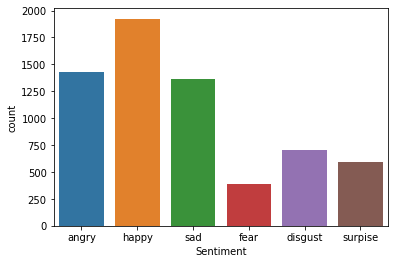

In [9]:
sns.countplot(df['Sentiment'])

In [10]:
df.Sentiment.value_counts(), len(df)

(happy      1924
 angry      1427
 sad        1366
 disgust     704
 surpise     592
 fear        392
 Name: Sentiment, dtype: int64, 6405)

In [11]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'decision tree':{
        'model':DecisionTreeClassifier(),
        'params':{
            'criterion':['entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'multinomial naive bayes':{
        'model':MultinomialNB(),
        'params':{
            'alpha':[.10,.15,.20,.25]
        }
    },
    'k nearest neibourgh':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors': [3,4,5,6,7]
            
        }
    },
    'Stochastic Gradient Descent':{
        'model':SGDClassifier(),
        'params':{
            'loss':['log']

        }
    },
    'XGBoost':{
        'model': XGBClassifier(),
        'params':{
            'booster':['gbtree', 'gblinear','dart']
        }
    }

}

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
x_bow = vect.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_bow,df['Label'] , test_size=0.2, random_state=42)

In [15]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score.sort_values(by=['best_score'],ascending=False) 

,model,best_score,best_params
3,logistic_regression,0.409606,{'C': 1}
0,svm,0.404142,"{'C': 20, 'kernel': 'rbf'}"
4,multinomial naive bayes,0.401992,{'alpha': 0.25}
6,Stochastic Gradient Descent,0.394767,{'loss': 'log'}
7,XGBoost,0.392037,{'booster': 'gbtree'}
1,random_forest,0.379342,{'n_estimators': 10}
5,k nearest neibourgh,0.355526,{'n_neighbors': 6}
2,decision tree,0.350449,{'criterion': 'entropy'}


In [16]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('Classification Report BOW')
from pprint import pprint as pp

pp(classification_report(y_test,y_pred))

Classification Report BOW
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.36      0.65      0.47       300\n'
 '           1       0.22      0.01      0.03       140\n'
 '           2       0.00      0.00      0.00        75\n'
 '           3       0.44      0.63      0.52       370\n'
 '           4       0.40      0.30      0.34       280\n'
 '           5       0.00      0.00      0.00       116\n'
 '\n'
 '    accuracy                           0.40      1281\n'
 '   macro avg       0.24      0.26      0.23      1281\n'
 'weighted avg       0.32      0.40      0.34      1281\n')


In [17]:
#TF-IDF unigram
tfidf_unigram = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_unigram= tfidf_unigram.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_unigram,df['Label'] , test_size=0.2, random_state=42)

In [18]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score.sort_values(by=['best_score'],ascending=False) 


,model,best_score,best_params
4,multinomial naive bayes,0.501759,{'alpha': 0.2}
3,logistic_regression,0.499221,{'C': 1}
6,Stochastic Gradient Descent,0.498831,{'loss': 'log'}
0,svm,0.491607,"{'C': 1, 'kernel': 'linear'}"
5,k nearest neibourgh,0.455878,{'n_neighbors': 7}
7,XGBoost,0.437920,{'booster': 'gbtree'}
1,random_forest,0.413126,{'n_estimators': 10}
2,decision tree,0.357478,{'criterion': 'entropy'}


In [19]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('Classification Report TF-IDF Unigram')
from pprint import pprint as pp

pp(classification_report(y_test,y_pred))

Classification Report TF-IDF Unigram
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.49      0.38      0.43       300\n'
 '           1       0.37      0.05      0.09       140\n'
 '           2       0.29      0.03      0.05        75\n'
 '           3       0.45      0.86      0.59       370\n'
 '           4       0.44      0.42      0.43       280\n'
 '           5       0.24      0.11      0.15       116\n'
 '\n'
 '    accuracy                           0.44      1281\n'
 '   macro avg       0.38      0.31      0.29      1281\n'
 'weighted avg       0.42      0.44      0.39      1281\n')


In [20]:
#TF-IDF Bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_bigram = tfidf_bigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_bigram,df['Label'] , test_size=0.2, random_state=42)

In [21]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score.sort_values(by=['best_score'],ascending=False) 


,model,best_score,best_params
4,multinomial naive bayes,0.505467,{'alpha': 0.1}
3,logistic_regression,0.504687,{'C': 5}
0,svm,0.504491,"{'C': 1, 'kernel': 'linear'}"
6,Stochastic Gradient Descent,0.499417,{'loss': 'log'}
5,k nearest neibourgh,0.446506,{'n_neighbors': 4}
7,XGBoost,0.443777,{'booster': 'gbtree'}
1,random_forest,0.430889,{'n_estimators': 10}
2,decision tree,0.354944,{'criterion': 'entropy'}


In [22]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('Classification Report TF-IDF Bigram')
from pprint import pprint as pp
pp(classification_report(y_test,y_pred))

Classification Report TF-IDF Bigram
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.50      0.38      0.43       300\n'
 '           1       0.41      0.06      0.11       140\n'
 '           2       0.31      0.05      0.09        75\n'
 '           3       0.45      0.85      0.58       370\n'
 '           4       0.42      0.39      0.40       280\n'
 '           5       0.29      0.14      0.19       116\n'
 '\n'
 '    accuracy                           0.44      1281\n'
 '   macro avg       0.40      0.31      0.30      1281\n'
 'weighted avg       0.43      0.44      0.39      1281\n')


In [23]:
#TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_trigram = tfidf_trigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_trigram,df['Label'] , test_size=0.2, random_state=42)

In [24]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score.sort_values(by=['best_score'],ascending=False) 


,model,best_score,best_params
0,svm,0.505076,"{'C': 10, 'kernel': 'linear'}"
4,multinomial naive bayes,0.504492,{'alpha': 0.1}
3,logistic_regression,0.504103,{'C': 10}
6,Stochastic Gradient Descent,0.491415,{'loss': 'log'}
5,k nearest neibourgh,0.449436,{'n_neighbors': 7}
7,XGBoost,0.440457,{'booster': 'gbtree'}
1,random_forest,0.421909,{'n_estimators': 10}
2,decision tree,0.363727,{'criterion': 'entropy'}


In [25]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('Classification Report TF-IDF Trigram')
from pprint import pprint as pp
pp(classification_report(y_test,y_pred))

Classification Report TF-IDF Trigram
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.50      0.37      0.43       300\n'
 '           1       0.27      0.03      0.05       140\n'
 '           2       0.27      0.04      0.07        75\n'
 '           3       0.46      0.87      0.60       370\n'
 '           4       0.42      0.41      0.42       280\n'
 '           5       0.28      0.12      0.17       116\n'
 '\n'
 '    accuracy                           0.45      1281\n'
 '   macro avg       0.37      0.31      0.29      1281\n'
 'weighted avg       0.41      0.45      0.39      1281\n')
